# Advanced Certification Programme in AI and MLOps
## A programme by IISc and TalentSprint
### Supplementary Notebook: Cats & Dogs Image Classfication
(Ungraded)

## Learning Objectives:

At the end of the experiment, you will be able to:

- build a ConvNet for  image classification using the cats-and-dogs dataset
- understand and apply data augmentation
- train the cnn model and evaluate its performance

## Image Classification


We will work with the cats-vs-dogs dataset to classify whether a given image is that of a cat or a dog .i.e a  binary classification problem.

### Import libraries

In [ ]:
import os
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from matplotlib.image import imread
import seaborn as sns
import numpy as np
from tensorflow.keras.utils import image_dataset_from_directory

In [ ]:
#@title Download the data
!wget -qq https://cdn.iisc.talentsprint.com/AIandMLOps/Datasets/cats_vs_dogs_small.zip
!unzip -qq '/content/cats_vs_dogs_small.zip'

In [ ]:
# defining path names for future use
data_dir = '/content/cats_vs_dogs_small'

train_path = data_dir + '/train'
validation_path = data_dir + '/validation'
test_path = data_dir + '/test'

shape of the dog image is: (254, 500, 3)
Mean across height of all dog images in train set is: 363.293
Mean across width of all dog images in train set is: 397.275


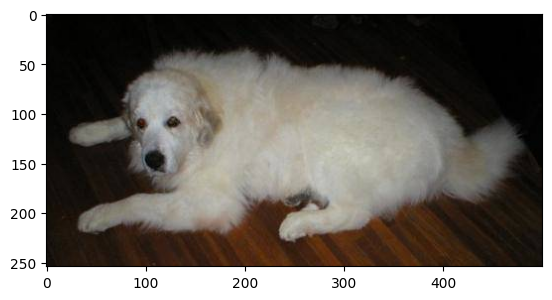

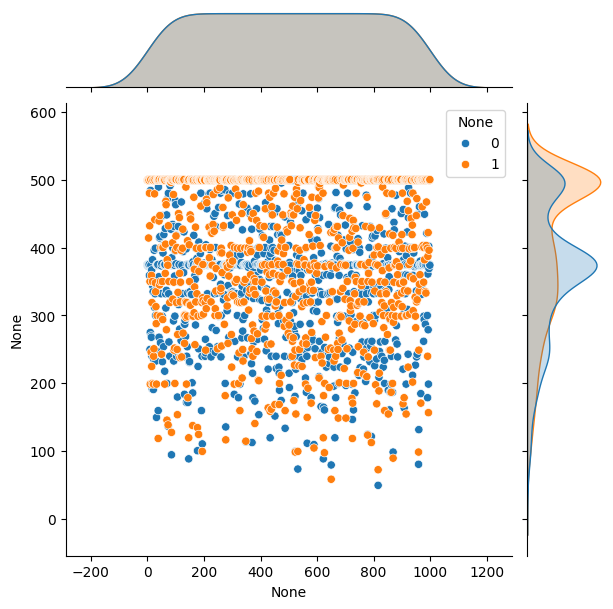

In [ ]:
# Visualise the original data
dog_image = train_path + '/dog/' +  'dog.443.jpg'
print("shape of the dog image is:",imread(dog_image).shape)
plt.imshow(imread(dog_image))

dim1 = []
dim2 = []

for image_file in os.listdir(train_path+'/dog'):
    img = imread(train_path +'/dog/'+image_file)
    d1,d2,colour_channels = img.shape
    dim1.append(d1)
    dim2.append(d2)

sns.jointplot((dim1,dim2))
print("Mean across height of all dog images in train set is:",np.mean(dim1))
print("Mean across width of all dog images in train set is:",np.mean(dim2))
# Q: Do all the images in the dataset have the same sizes? A: No

### Converting the image dataset into a workable format

We have the images in folders. We need to make it into a workable dataset:
  * Which has labels
  * All the images have the same size

For this, we will use the utility [**image_dataset_from_directory**](https://www.tensorflow.org/api_docs/python/tf/keras/utils/image_dataset_from_directory).

Calling `image_dataset_from_directory(main_directory, labels='inferred')` will return a `tf.data.Dataset` that yields batches of images from the subdirectories `class_a` and `class_b`, together with labels 0 and 1 (0 corresponding to `class_a` and 1 corresponding to `class_b`).

In [ ]:
image_size = (180, 180)
batch_size = 32

train_dataset = image_dataset_from_directory(train_path,
                                             image_size = image_size, # Resize the images to (180,180)
                                             batch_size = batch_size)

validation_dataset = image_dataset_from_directory(validation_path,
                                                  image_size = image_size,
                                                  batch_size = batch_size)

test_dataset = image_dataset_from_directory(test_path,
                                            image_size = image_size,
                                            batch_size = batch_size)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 2000 files belonging to 2 classes.


In [ ]:
print(f"train_dataset = {train_dataset}")

train_dataset = <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 180, 180, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>


In [ ]:
# Verify batch size
for data_batch, labels_batch in train_dataset:
    print("data batch shape:", data_batch.shape)
    print("labels batch shape:", labels_batch.shape)
    break


data batch shape: (32, 180, 180, 3)
labels batch shape: (32,)


In [ ]:
for data_batch, labels_batch in train_dataset:
    print(data_batch[0].shape)
    print(labels_batch[0])
    break


(180, 180, 3)
tf.Tensor(1, shape=(), dtype=int32)


## Data Augmentation

The small dataset can cause a high variance estimation of model performance

Q: How to overcome this and get a more robust model?

Now, we want to avoid this problem altogether by artificially (and cleverly) producing new data from the already available data.

For this, we perform **data augmentation**.

Data augmentation is another regularization method. It takes the approach of generating more training data from existing training samples by augmenting the samples via a number of random transformations that yield a believable-looking image.

Common transformations include:
  * Flipping the image
  * Rotating the image
  * Zooming in/out of the image

See some sample images below after augmentation:

![picture](https://drive.google.com/uc?export=view&id=1HRhsHEHtcVptNVMF1EbCGiZX5XuTdrs5)

In [ ]:
# Performing the data augmentation as series of transformations
def get_data_augmented(flip="horizontal", rotation=0.1, zoom=0.2):

    data_augmentation = keras.Sequential([keras.layers.RandomFlip(flip),
                                          keras.layers.RandomRotation(rotation),
                                          keras.layers.RandomZoom(zoom)])

    return data_augmentation

data_augmentation = get_data_augmented()

### Build Model

In [ ]:
inputs = keras.Input(shape=(180, 180, 3))
# Augmenting data - Transformations of images by random factors
# so that the network never sees the same data twice
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(x)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)

model = keras.Model(inputs=inputs, outputs=outputs)

model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

#### Call Back Function

In [ ]:
# Define a function to return a commmonly used callback_list
def def_callbacks(filepath, mod_chk_mon = "val_loss", earlystop = 0 ):
    callback_list = []

    # Defualt callback
    callback_list.append(keras.callbacks.ModelCheckpoint(filepath,
                                                         save_best_only = True,
                                                         monitor = mod_chk_mon))

    if earlystop > 0:
        callback_list.append(keras.callbacks.EarlyStopping(patience = earlystop))

    return callback_list

### Train Model

In [ ]:
PARTIAL_RUN = False
epochs = 80
if PARTIAL_RUN:
    epochs = 2
history = model.fit(train_dataset,
                    epochs = epochs,
                    validation_data = validation_dataset,
                    callbacks = def_callbacks("convnet_from_scratch_with_augmentation.keras"))

Epoch 1/80
63/63 [==============================] - 13s 84ms/step - loss: 0.6962 - accuracy: 0.5055 - val_loss: 0.6929 - val_accuracy: 0.5000
Epoch 2/80
63/63 [==============================] - 5s 68ms/step - loss: 0.7223 - accuracy: 0.4995 - val_loss: 0.6934 - val_accuracy: 0.4890
Epoch 3/80
63/63 [==============================] - 4s 58ms/step - loss: 0.6948 - accuracy: 0.4840 - val_loss: 0.6932 - val_accuracy: 0.5020
Epoch 4/80
63/63 [==============================] - 4s 57ms/step - loss: 0.6924 - accuracy: 0.5325 - val_loss: 0.6940 - val_accuracy: 0.5080
Epoch 5/80
63/63 [==============================] - 5s 69ms/step - loss: 0.6972 - accuracy: 0.5625 - val_loss: 0.7227 - val_accuracy: 0.5080
Epoch 6/80
63/63 [==============================] - 4s 58ms/step - loss: 0.6810 - accuracy: 0.5910 - val_loss: 0.6287 - val_accuracy: 0.6540
Epoch 7/80
63/63 [==============================] - 4s 58ms/step - loss: 0.6528 - accuracy: 0.6440 - val_loss: 0.6702 - val_accuracy: 0.5980
Epoch 8/80
6

### Model Performance

In [ ]:
test_model = keras.models.load_model("convnet_from_scratch_with_augmentation.keras")

test_loss, test_acc = test_model.evaluate(test_dataset)

print(f"Test accuracy: {test_acc:.3f}")

63/63 [==============================] - 3s 46ms/step - loss: 0.4664 - accuracy: 0.8525
Test accuracy: 0.853


With data augmentation, we roughly get **82-85%** accuracy.